In [1]:
from sklearn.datasets import fetch_mldata
from collections import Counter
import tempfile
from six.moves import urllib
import pickle
test_data_home = tempfile.mkdtemp()
try:
    mnist = fetch_mldata('MNIST original',data_home=test_data_home)
except:
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    pickle.dump(mnist,open('mnist.p'),2)

In [5]:
import numpy as np
from sklearn import neighbors, neural_network, preprocessing, decomposition, manifold
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#py.init_notebook_mode(connected=True)

shuffled = np.arange(mnist.data.shape[0])
np.random.shuffle(shuffled)
data = mnist.data[shuffled,:]
labels = mnist.target[shuffled]
accuracy = [[],[]]
N = 10
c = ['hsl(' + str(h) + ',50%' + ',50%)' for h in np.linspace(0, 360, N + 1)]
for j,i in enumerate(range(0,data.shape[0],700)):
    scaler = preprocessing.StandardScaler()
    train_data = data[i:i+600]
    scaler.fit(train_data)
    train_labels = labels[i:i+600]
    test_data = data[i+600:i+700]
    test_labels = labels[i+600:i+700]
    models = [neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'euclidean'),neural_network.MLPClassifier(hidden_layer_sizes = (50, 100, 50))]
    colors = [np.vectorize(lambda x: c[int(x)])(test_labels)]
    plot_names = np.vectorize(lambda x: 'Actual Handwritten Digit: %d'%(int(x)))(test_labels)
    cluster_names = [np.vectorize(lambda x: 'Found Digit = %d'%(int(x)))(test_labels)]
    labels_2 = [test_labels]
    for idx, model in enumerate(models):
        if idx == 0:
            #pca = decomposition.PCA(n_components = 3)
            #pca.fit(train_data)
            #transformed_test_data = LinearDiscriminantAnalysis(n_components=3).fit(train_data,train_labels).transform(test_data)
            #transformed_test_data = pca.transform(test_data)
            #pca = decomposition.PCA(n_components = 10).fit(train_data)
            #train_data2 = pca.transform(train_data)
            #test_data2 = pca.transform(test_data)
            transformed_test_data = decomposition.PCA(n_components = 3).fit(train_data).transform(test_data)
            #model.fit(train_data2, train_labels)
            #labels_predicted = model.predict(test_data2)
            #tsne = manifold.TSNE(n_components = 3)
            #tsne.fit_transform(t_data)
            #transformed_test_data = tsne.transform(test_data)
        if idx == 1:
            train_data = scaler.transform(train_data)
            test_data = scaler.transform(test_data)
        model.fit(train_data, train_labels)
        labels_predicted = model.predict(test_data)
        labels_2.append(labels_predicted)
        accuracy[idx].append(sum(labels_predicted == test_labels))
        colors.append(np.vectorize(lambda x: c[int(x)])(labels_predicted))
        cluster_names.append(np.vectorize(lambda x: 'Found Digit = %d'%(int(x)))(labels_predicted))
    #pca = decomposition.PCA(n_components = 3)
    #pca.fit(train_data)
    #transformed_test_data = pca.transform(test_data)
    
    sliders_dict = {
                'active': 0,
                'yanchor': 'top',
                'xanchor': 'left',
                'currentvalue': {
                    'font': {'size': 20},
                    'prefix': 'Frame:',
                    'visible': True,
                    'xanchor': 'right'
                },
                'transition': {'duration': 300, 'easing': 'cubic-in-out'},
                'pad': {'b': 10, 't': 50},
                'len': 0.9,
                'x': 0.1,
                'y': 0,
                'steps': [{'args': [
            [str(nm)],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
             'transition': {'duration': 300}}
            ],
            'label': str(nm),
            'method': 'animate'} for nm in ['Actual Handwritten Digits','Nearest Neighbors Predicted Digits', 'Neural Network Predicted Digits']]
            }
    masterData = []
    for idx,nm in enumerate(['Actual Handwritten Digits','Nearest Neighbors Predicted Digits', 'Neural Network Predicted Digits']):
        masterData.append({'data': go.Data([go.Scatter3d(x=transformed_test_data[labels_2[idx] == k,0],y=transformed_test_data[labels_2[idx] == k,1],z=transformed_test_data[labels_2[idx] == k,2],mode='markers',name=cluster_names[idx][labels_2[idx] == k],
                                      marker=go.Marker(symbol='dot',
                                                       size=5,
                                                       color=colors[idx][labels_2[idx] == k],
                                                       line=go.Line(color='rgb(50,50,50)', width=0.5)
                                                       ),
                                      text=plot_names[labels_2[idx] == k],
                                      hoverinfo='text'
                                      ) for k in set(labels_2[idx])]), 'name': nm })
    axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title=''
            )
    masterLayout = dict(
        title="Plots of Classifier Results For Training of 600 digits and Testing of 100 Digits",
        updatemenus=[{'direction': 'left',
                      'pad': {'r': 10, 't': 87},
                      'showactive': False,
                      'type': 'buttons',
                      'x': 0.1,
                      'xanchor': 'right',
                      'y': 0,
                      'yanchor': 'top', 'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': False},
                                    'fromcurrent': True,
                                    'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                                      'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ]}],
        sliders=[sliders_dict],
        width=1000,
        height=600,
        showlegend=True,
        scene=go.Scene(
            xaxis=go.XAxis(axis),
            yaxis=go.YAxis(axis),
            zaxis=go.ZAxis(axis),
        ),
        margin=go.Margin(
            t=100
        ),
        hovermode='closest',
        annotations=go.Annotations([
            go.Annotation(
                showarrow=False,
                text="",
                xref='paper',
                yref='paper',
                x=0,
                y=0.1,
                xanchor='left',
                yanchor='bottom',
                font=go.Font(
                    size=14
                )
            )
        ]), )
    py.plot(go.Figure(data=masterData[0]['data'], layout=masterLayout, frames=masterData), filename = './output_stats_project/classifier_results_%d.html'%j, auto_open = False)
    
print(accuracy)

/Users/JoshuaLevy/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning:

Data with input dtype uint8 was converted to float64 by StandardScaler.



[[87, 84, 90, 78, 86, 78, 80, 90, 82, 82, 83, 83, 77, 87, 82, 80, 88, 86, 90, 78, 84, 76, 83, 87, 88, 77, 86, 86, 86, 87, 73, 87, 84, 83, 87, 86, 85, 86, 78, 88, 81, 84, 87, 88, 80, 86, 85, 77, 89, 84, 81, 90, 79, 83, 81, 86, 88, 87, 83, 84, 81, 86, 86, 89, 90, 88, 84, 81, 82, 83, 90, 82, 85, 82, 79, 84, 79, 85, 86, 82, 85, 81, 85, 83, 86, 85, 85, 80, 78, 82, 86, 88, 86, 83, 82, 87, 85, 87, 83, 83], [84, 85, 87, 81, 84, 82, 79, 86, 82, 84, 83, 85, 84, 91, 90, 80, 89, 86, 82, 84, 87, 80, 83, 81, 89, 82, 82, 86, 83, 87, 82, 82, 91, 83, 84, 88, 84, 84, 82, 86, 85, 85, 90, 86, 83, 87, 87, 82, 77, 86, 84, 82, 82, 82, 86, 90, 85, 79, 84, 88, 82, 90, 86, 85, 90, 85, 84, 83, 76, 81, 87, 88, 82, 82, 79, 85, 85, 89, 89, 89, 87, 85, 83, 85, 84, 88, 85, 81, 81, 86, 79, 82, 80, 88, 81, 84, 85, 81, 76, 81]]


/Users/JoshuaLevy/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



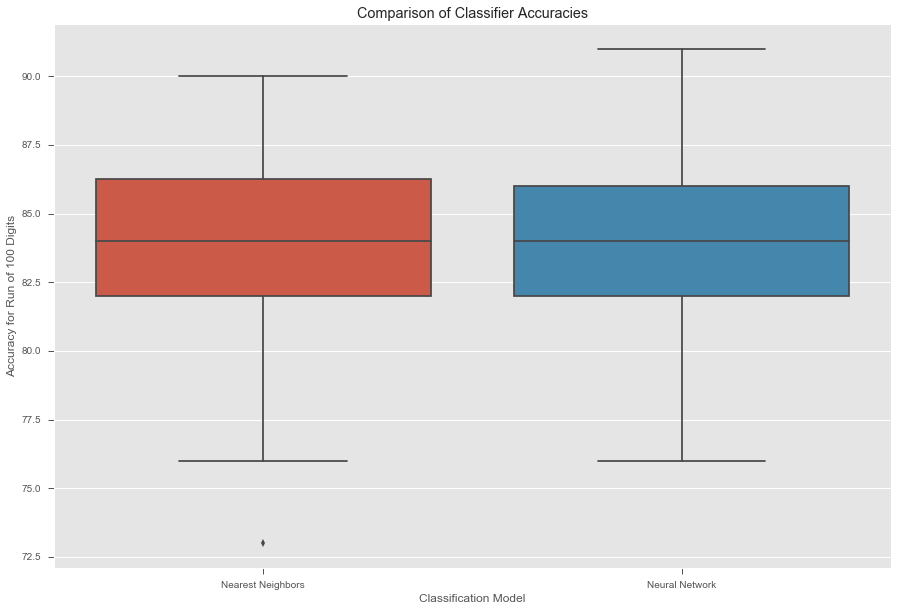

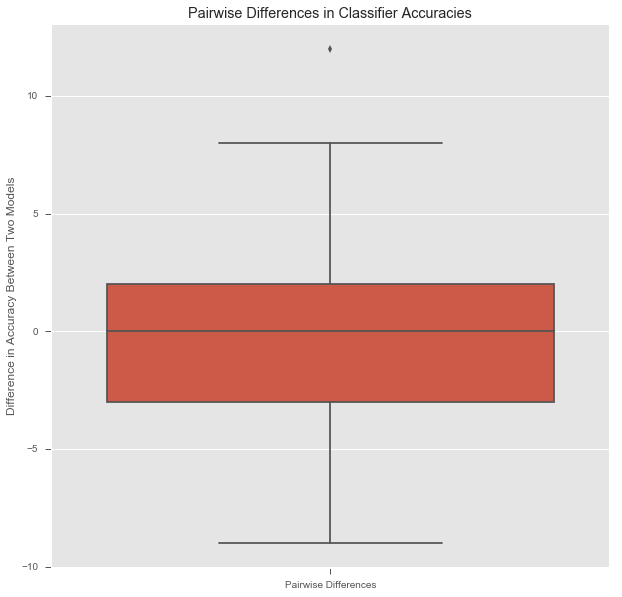

In [6]:
import seaborn as sns
import pandas as pd
sns.set(style="ticks")
import matplotlib.pyplot as plt
model_names = ['Nearest Neighbors', 'Neural Network']
plt.style.use('ggplot')
plt.figure(figsize=[15,10])
sns.boxplot(x='variable',y='value',data=pd.melt(pd.DataFrame({'Nearest Neighbors':accuracy[0],'Neural Network':accuracy[1]})))
plt.xlabel('Classification Model')
plt.ylabel('Accuracy for Run of 100 Digits')
plt.title('Comparison of Classifier Accuracies')
plt.legend()
plt.savefig('Classifier_Boxplots.png')
plt.show()
plt.figure(figsize=[10,10])
plt.title('Pairwise Differences in Classifier Accuracies')
sns.boxplot(x='variable',y='value',data=pd.melt(pd.DataFrame({'Pairwise Differences':np.array(accuracy[0])-np.array(accuracy[1])})))
plt.xlabel('')
plt.ylabel('Difference in Accuracy Between Two Models')
plt.savefig('Pair_Boxplots.png')
plt.show()

In [7]:
import pandas as pd
final_data = pd.DataFrame({'Nearest Neighbors':accuracy[0],'Neural Network':accuracy[1],'Pairwise Accuracy Differences':np.array(accuracy[0])-np.array(accuracy[1])})
final_data.to_csv('classifier_accuracy_out.csv',index=False)